In [596]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold


In [597]:
#df_All = pd.read_csv(r"C:\Users\saust\OneDrive - Sasol\1 Project rC4\Jupyter Notebooks\Report 10-20-23 No Fluff\df_All_Avg.csv")

#df_All = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\CodeSpace DLs\102423\Project rC4\5 Engineered Features\3 - EF - Feature Selection\df_CDCA.csv")
df_All = pd.read_csv('/workspaces/codespaces-jupyter/ProjectrC4/df_AlConCD554.csv')


In [598]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [599]:
# List of columns to exclude to run XGboost feature selection
exclude_columns = [#'Date', 
                   #'FFC55553' ,'LC55555', 'FC55003', 'LC55557', 'FFC55555','LC55553', 
                   'TI55021', 'TC55555', 'Decanol'
                   
                   ]

# Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

In [600]:
df_All.columns

Index(['Butanol', '425 %Al', 'TC55552', 'DI55102', 'FC55569', 'DI55152',
       'FC55576', 'TI55017', 'FC42428', 'AYC55580', 'LC55555', 'TI55023',
       'FFC55553', 'FC55555', 'FC55009', 'LC55557', 'LC55553', 'FC55003',
       'FFC55555', 'Date'],
      dtype='object')

In [601]:
df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [602]:
df_All.drop('Date', axis=1, inplace=True)




In [603]:
print(df_All.describe())

            Butanol       425 %Al       TC55552       DI55102       FC55569  \
count  12718.000000  12718.000000  12718.000000  12718.000000  12718.000000   
mean      10.682271      5.928132    164.486979      0.882777   6418.380490   
std       12.116228      0.374842     12.500750      0.085052    397.647827   
min        0.100000      4.573810    120.114000      0.794808   5142.080000   
25%        3.123935      5.784038    158.524000      0.794863   6135.472500   
50%        5.451665      6.008620    165.515000      0.881021   6420.345000   
75%       12.800850      6.178960    173.455000      0.968991   6709.925000   
max       60.346700      7.096060    207.426000      1.032950   7806.490000   

            DI55152       FC55576       TI55017       FC42428      AYC55580  \
count  12718.000000  12718.000000  12718.000000  12718.000000  12718.000000   
mean       1.001901    527.911065    188.358947  29476.385886      8.322303   
std        0.037287    262.282229      9.138614   5

In [604]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
X = df_All.drop('Butanol', axis=1)  # Replace 'target_column_name' with your target column's name
y = df_All['Butanol']

In [605]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [606]:
# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.03,
    n_estimators=800,
    max_depth=9,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.5,
    alpha=0.1,
    reg_lambda=1,
    colsample_bylevel=0.8,
    colsample_bynode=0.7
)
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=0.8,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [607]:
# Predict on training data
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on Training Data: {mse_train}")



# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Data: {mse}")

Mean Squared Error on Training Data: 0.28861753828074643
Mean Squared Error on the Testing Data: 13.565197342726325


In [608]:
rmse_train = np.sqrt(mse_train)
print(f"Root Mean Squared Error on Training Data: {rmse_train}")


rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on the Testing Data: {rmse}")


Root Mean Squared Error on Training Data: 0.537231363828236
Root Mean Squared Error on the Testing Data: 3.683096162568434


In [609]:
# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f"R-squared value on Training Data:: {r2_train:.2f}")


# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared value on the Testing Data: {r2:.2f}")

R-squared value on Training Data:: 1.00
R-squared value on the Testing Data: 0.91


In [610]:
current_features = X.columns.tolist()

# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    """
    Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
    Args:
    - r2 (float): R^2 value
    - n (int): number of samples
    - k (int): number of predictors

    Returns:
    - float: adjusted R^2 value
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))

print(f"Adjusted R^2 value: {adj_r2}")

Adjusted R^2 value: 0.9114502818086844


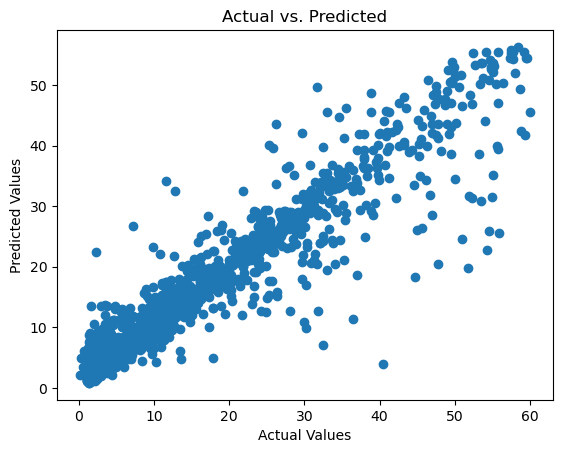

In [611]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()


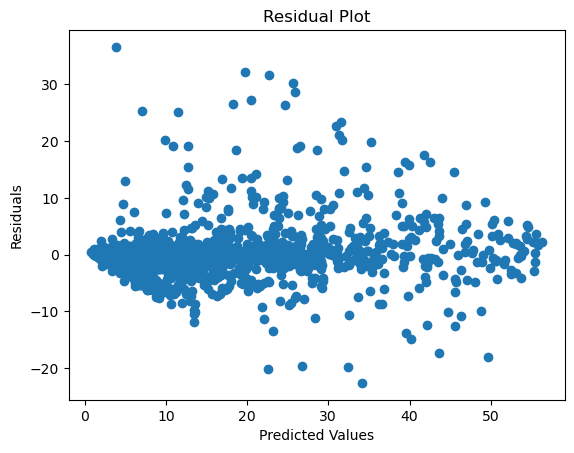

In [612]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [613]:
num_rows = df_All.shape[0]

splits = num_rows//10000

if splits < 5:
    splits = 5

In [614]:
# # Define the K-fold cross validator
# kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# # Perform K-fold cross-validation
# scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# # Take the square root of the scores to get the RMSE
# rmse_scores = np.sqrt(-scores)

# # Print out the results
# print(f'Scores for each fold are: {rmse_scores}')
# print(f'Average RMSE: {np.mean(rmse_scores)}')
# print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

In [615]:
df_All.columns

Index(['Butanol', '425 %Al', 'TC55552', 'DI55102', 'FC55569', 'DI55152',
       'FC55576', 'TI55017', 'FC42428', 'AYC55580', 'LC55555', 'TI55023',
       'FFC55553', 'FC55555', 'FC55009', 'LC55557', 'LC55553', 'FC55003',
       'FFC55555'],
      dtype='object')